Acurácia do LinearRegression: 100.0%


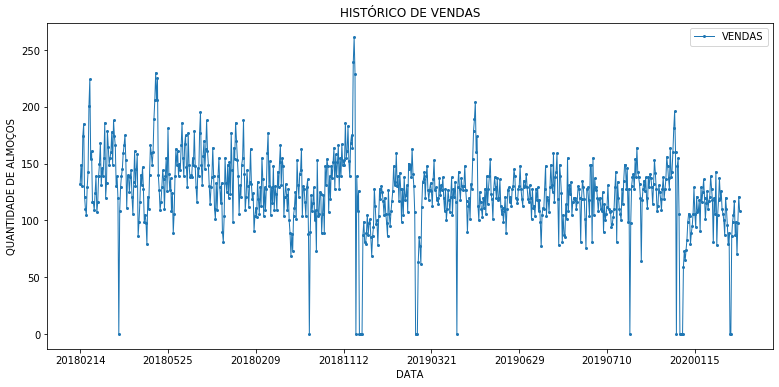

In [247]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from matplotlib import style

# configs
mpld3.enable_notebook()
warnings.filterwarnings("ignore")

# read csvs & build dataframe
df = pd.DataFrame()
df_temp = pd.read_csv('./datasets/temperatura_featured.csv')
df_vendas = pd.read_csv('./datasets/vendas.csv', ';')
df_conc = pd.read_csv('./datasets/concorrentes.csv', ';')

# pre processing
def get_dias_fechados():
    return ['2018-03-30', '2018-11-02', '2018-12-25', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-03-03', '2019-03-04', '2019-03-05', '2019-04-19', '2019-11-02', '2019-12-25', '2019-12-29', '2019-12-30', '2019-12-31', '2020-01-01', '2020-02-24', '2020-02-25']

def get_dias_fds():
    return ['Sunday', 'Saturday']

def get_dias_feriados():
    return ['2018-03-30', '2018-04-21', '2018-04-30', '2018-05-01', '2018-05-31', '2018-06-01', '2018-09-07', '2018-10-12', '2018-11-02', '2018-11-15', '2018-11-16', '2018-12-24', '2018-12-25', '2018-12-29', '2018-12-30', '2018-12-31', 
'2019-01-01', '2019-03-04', '2019-03-05', '2019-04-19', '2019-04-21', '2019-05-01', '2019-06-20', '2019-06-21', '2019-09-07', '2019-10-12', '2019-11-02', '2019-11-15', '2019-12-25', '2019-12-25', '2019-12-25', '2019-12-30', '2019-12-31', 
'2020-01-01', '2020-02-24', '2020-02-25']

def get_dias_festivos():
    return ['2018-05-13', '2018-08-12', '2018-12-25', '2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01', '2019-03-03', '2019-03-04', '2019-03-05', '2019-05-12', '2019-08-11', '2019-12-25', '2019-12-29', '2019-12-30', '2019-12-31', '2020-01-01', '2020-02-24', '2020-02-25']

def get_vesperas_dias_festivos():
    vesperas = []
    for i in range(len(get_dias_festivos())):
        vesperas_dia_festivo_current = pd.Series(pd.date_range(end=get_dias_festivos()[i], periods=5, closed='left'))
        for j in range(len(vesperas_dia_festivo_current)):
            vesperas.append(vesperas_dia_festivo_current[j])
    return vesperas

def get_pos_dias_festivos():
    pos = []
    for i in range(len(get_dias_festivos())):
        pos_dia_festivo_current = pd.Series(pd.date_range(get_dias_festivos()[i], periods=3, closed='right'))
        for j in range(len(pos_dia_festivo_current)):
            pos.append(pos_dia_festivo_current[j])
    return pos

def get_dias_acerca_pagamento():
    return [5,6,7,8,9,10,28,29,30,31]

def get_meses_baixas_temporadas():
    return [1, 2]

# featured engineering
df.insert(loc=0, column='DATA', value=(pd.to_datetime(df_vendas['DATA']).dt.strftime("%Y%m%d")))
df.insert(loc=1, column='VENDAS', value=(df_vendas['VENDAS'].fillna(0).astype(int)))
df.insert(loc=2, column='IS_FECHADO', value=(pd.DatetimeIndex(df_temp['DATA']).isin(get_dias_fechados()).astype(int)))
df.insert(loc=3, column='IS_FDS', value=(pd.DatetimeIndex(df_temp['DATA']).day_name().isin(get_dias_fds())).astype(int))
df.insert(loc=4, column='IS_FERIADO', value=(pd.DatetimeIndex(df_temp['DATA']).isin(get_dias_feriados())).astype(int))
df.insert(loc=5, column='IS_DATA_FESTIVA', value=(pd.DatetimeIndex(df_temp['DATA']).isin(get_dias_festivos())).astype(int))
df.insert(loc=6, column='IS_VESPERA_DATA_FESTIVA', value=(pd.DatetimeIndex(df_temp['DATA']).isin(get_vesperas_dias_festivos())).astype(int))
df.insert(loc=7, column='IS_POS_DATA_FESTIVA', value=(pd.DatetimeIndex(df_temp['DATA']).isin(get_pos_dias_festivos())).astype(int))
df.insert(loc=8, column='IS_SEMANA_PAGAMENTO', value=(pd.DatetimeIndex(df_temp['DATA']).day.astype(int).isin(get_dias_acerca_pagamento()).astype(int)))
df.insert(loc=9, column='IS_BAIXA_TEMPORADA', value=(pd.DatetimeIndex(df_temp['DATA']).month.isin(get_meses_baixas_temporadas()).astype(int)))
df.insert(loc=10, column='QTD_CONCORRENTES', value=(df_conc['CONCORRENTES'].fillna(0).astype(int)))
df.insert(loc=11, column='PRECIPITACAO', value=(df_temp['PRECIPITACAO']))
df.insert(loc=12, column='TEMPERATURA', value=(df_temp['TEMPERATURA']))
df.insert(loc=13, column='UMIDADE', value=(df_temp['UMIDADE']))

# input & output
X = df.drop(columns=['VENDAS'])
y = df.drop(columns=['IS_FECHADO', 'IS_FDS', 'IS_FERIADO', 'IS_DATA_FESTIVA', 'IS_VESPERA_DATA_FESTIVA', 'IS_POS_DATA_FESTIVA', 'IS_SEMANA_PAGAMENTO', 'IS_BAIXA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE'])

# standardization & normalization
X = preprocessing.scale(X)

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# training the model
model = LinearRegression(n_jobs=-1) 
model.fit(X_train, y_train)

# check accuracy
accuracy = model.score(X_test, y_test)
print(f'Acurácia do LinearRegression: {round(accuracy*100, 2)}%')

# create forecast column
df.insert(loc=2, column='VENDAS_FORECAST', value=(np.nan))

# plot chart
df.plot(y='VENDAS', x='DATA', figsize=(13, 6), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.legend(loc=1)
plt.title('HISTÓRICO DE VENDAS')
plt.xlabel('DATA')
plt.ylabel('QUANTIDADE DE ALMOÇOS')
plt.show()